## Class 4: Other Data Analysis Techniques

### Data Analysis and Regression
Tobias Rodriguez del Pozo, 2025

#### Outline for Today

1. PCA
2. Boosting and Bagging
3. Tree-based methods and Random Forests

### Principal Component Analysis (PCA)

A lot of the time, we have a lot of features. So, we could look at a correlation matrix to understand how they're related, but another way to do this would be to understand the "shape" of the data.

PCA is a powerful tool as it allows us to reduce the dimensionality of the data, while retaining as much information about the data as possible.

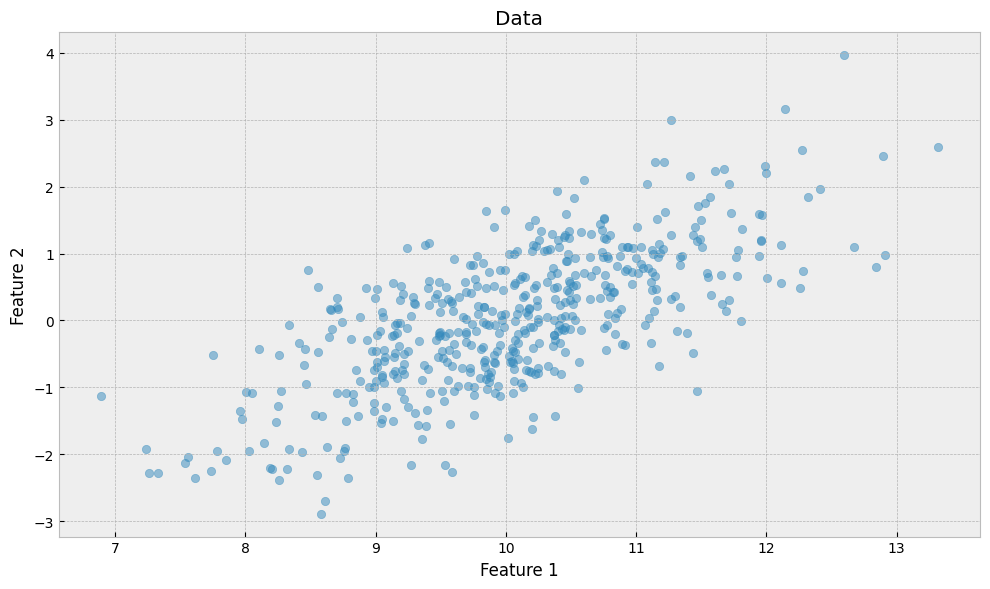

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use('bmh')


# Mean and covariance for positive correlation
mean = [10, 0]
cov = [[1, 0.7], [0.7, 1]]  # 0.1 indicates weak positive correlation

# Generate 500 samples
data = np.random.multivariate_normal(mean, cov, 500)

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
plt.title('Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()

Really this dataset has some variation in the X and Y directions, but what's most interesting is that the data lies along this diagonal line.

What PCA does is it tries to find the "directions" of the data, which are called principal components. These aim to capture the most *variance* in the data.

More formally, PCA finds the eigenvectors of the covariance matrix of the data, these eigenvectors are the directions of the maximum variance, and the eigenvalues are the amount of variance in each direction. That is, each principal component from: $1,...,k$ corresponds to the vector $v_i$ that maximizes the variance of the data projected onto that vector, and is *orthogonal* to the previous principal components.

The way I intuitively think about eigenvectors is that they're the shape of the data -- so I can move my data around (linear transformations) but because it's the same data, the shape doesn't change.

In practice, we normally use SVD to compute PCA, since it saves us from computing the covariance matrix explicity, and is also more numerically stable when things are collinear.

$$
\text{PCA}(X) = U \Sigma V^T
$$

Where $U$ is the matrix of left singular vectors (the eigenvectors of $XX^T$), $\Sigma$ is the diagonal matrix of singular values (the square roots of the eigenvalues of $X^TX$), and $V$ is the matrix of right singular vectors (the eigenvectors of $X^TX$).

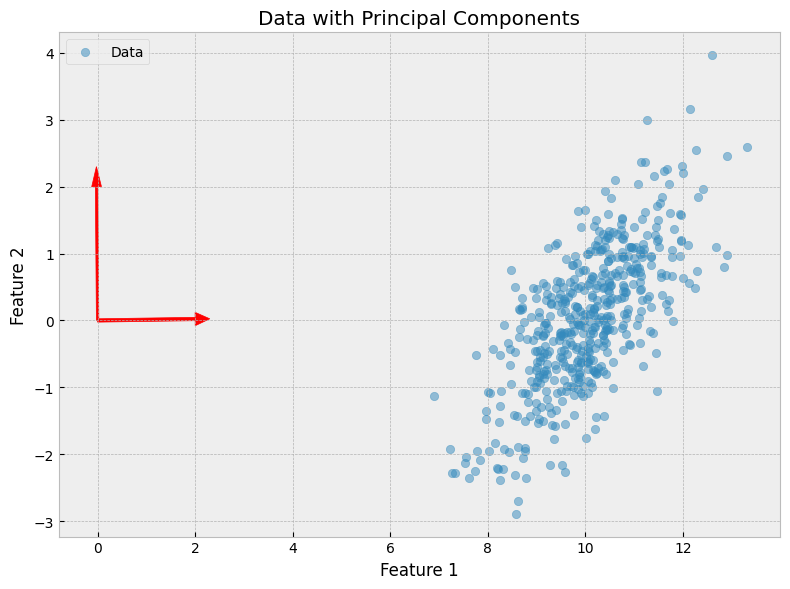

In [2]:
# Do SVD on data
u, s, vh = np.linalg.svd(data)

plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Data')
origin = (0, 0) #np.mean(data, axis=0)
for comp in vh * -1:
    vec = comp * 2  # scale for visualization
    plt.arrow(origin[0], origin[1], vec[0], vec[1], color='red', width=0.05, head_width=0.2)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data with Principal Components')
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
pd.DataFrame(vh, columns=['Feature 1', 'Feature 2'], index=['PC1', 'PC2'])

,Feature 1,Feature 2
PC1,-0.999942,-0.010739
PC2,0.010739,-0.999942


What's going on?!?

Well, remember that these vectors start at the origin(0, 0) -- I could move them around but the direction is still weird? One is pointing up/down and one is pointing left/right.

What's happening is that the *direction* of maximum variance, for data far away from the origin is going to be the x or y axis, since the biggest source of variance is the distance from the origin -- not anything about the shape of the data. [link](
https://stats.stackexchange.com/questions/189822/how-does-centering-make-a-difference-in-pca-for-svd-and-eigen-decomposition#:~:text=Centered%20and%20non-centered%20data,does%20not%20make%20any%20difference.)

We can get around this by either going back to the covariance approach, or by "centering" the data (subtracting the mean), so that we remove the distance from the mean as a source of variance.

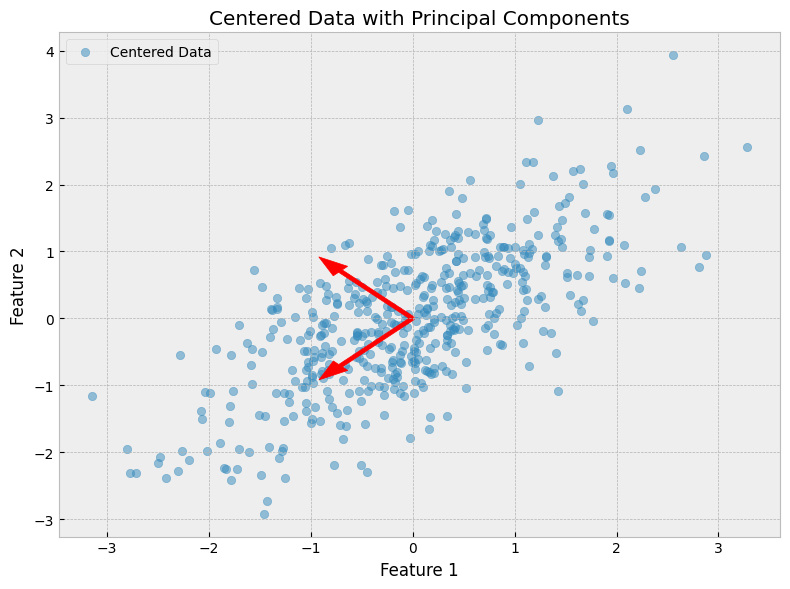

In [4]:
data_centered = data - np.mean(data, axis=0)
u_c, s_c, vh_c = np.linalg.svd(data_centered)

plt.figure(figsize=(8, 6))
plt.scatter(data_centered[:, 0], data_centered[:, 1], alpha=0.5, label='Centered Data')
origin = (0, 0) #np.mean(data, axis=0)
for comp in vh_c * -1:
    vec = comp  # scale for visualization
    plt.arrow(origin[0], origin[1], vec[0], vec[1], color='red', width=0.05, head_width=0.2)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Centered Data with Principal Components')
plt.legend()
plt.tight_layout()
plt.show()

Much better, this makes a lot of sense. If we think about PCA as being the shape of the covariance matrix, then it follows that we should be *really* confident in our covariance estimates. In finance this matters a lot because of regimes, and so we might want to use different weighting schemes on the data, before calculating PCA.

Now that we have a PCA...what do we do with it? Well, PCA is typically used for dimensionality reduction. So, we want to "compress" our data into a lower-dimensional space.

We can interpret our PCA results in a few ways.

First, we can look at the explained variance ratio of each component. This tells us how much of the total variance in the data is accounted for by each PC.

$$
\text{Explained Variance Ratio} = \frac{\lambda_i}{\sum_{j=1}^{k} \lambda_j}
$$

Where $\lambda$ is the eigenvalue.

Second, we can look at the loadings of *each* component. This tells us how much each original variable contributes to the component. This is the coefficient that we need to scale our data by when projecting it onto the PCA space.

Typically, you want to visualize your PCA loadings to understand the relationship between your original variables and the components. One famous finding in finance (that someone at Goldman Sachs many, many years ago discovered) is the famous level, slope, and curvature factors that drive yield curve movements.

--- Explained Variance by Component---
Principal Component 1: 0.6597 (65.97%)
Principal Component 2: 0.2626 (26.26%)
Principal Component 3: 0.0755 (7.55%)
Principal Component 4: 0.0004 (0.04%)
Principal Component 5: 0.0004 (0.04%)
Principal Component 6: 0.0003 (0.03%)
Principal Component 7: 0.0003 (0.03%)
Principal Component 8: 0.0003 (0.03%)
Principal Component 9: 0.0002 (0.02%)
Principal Component 10: 0.0002 (0.02%)
-----------------------------------
Total variance explained by first 3 components: 99.79%



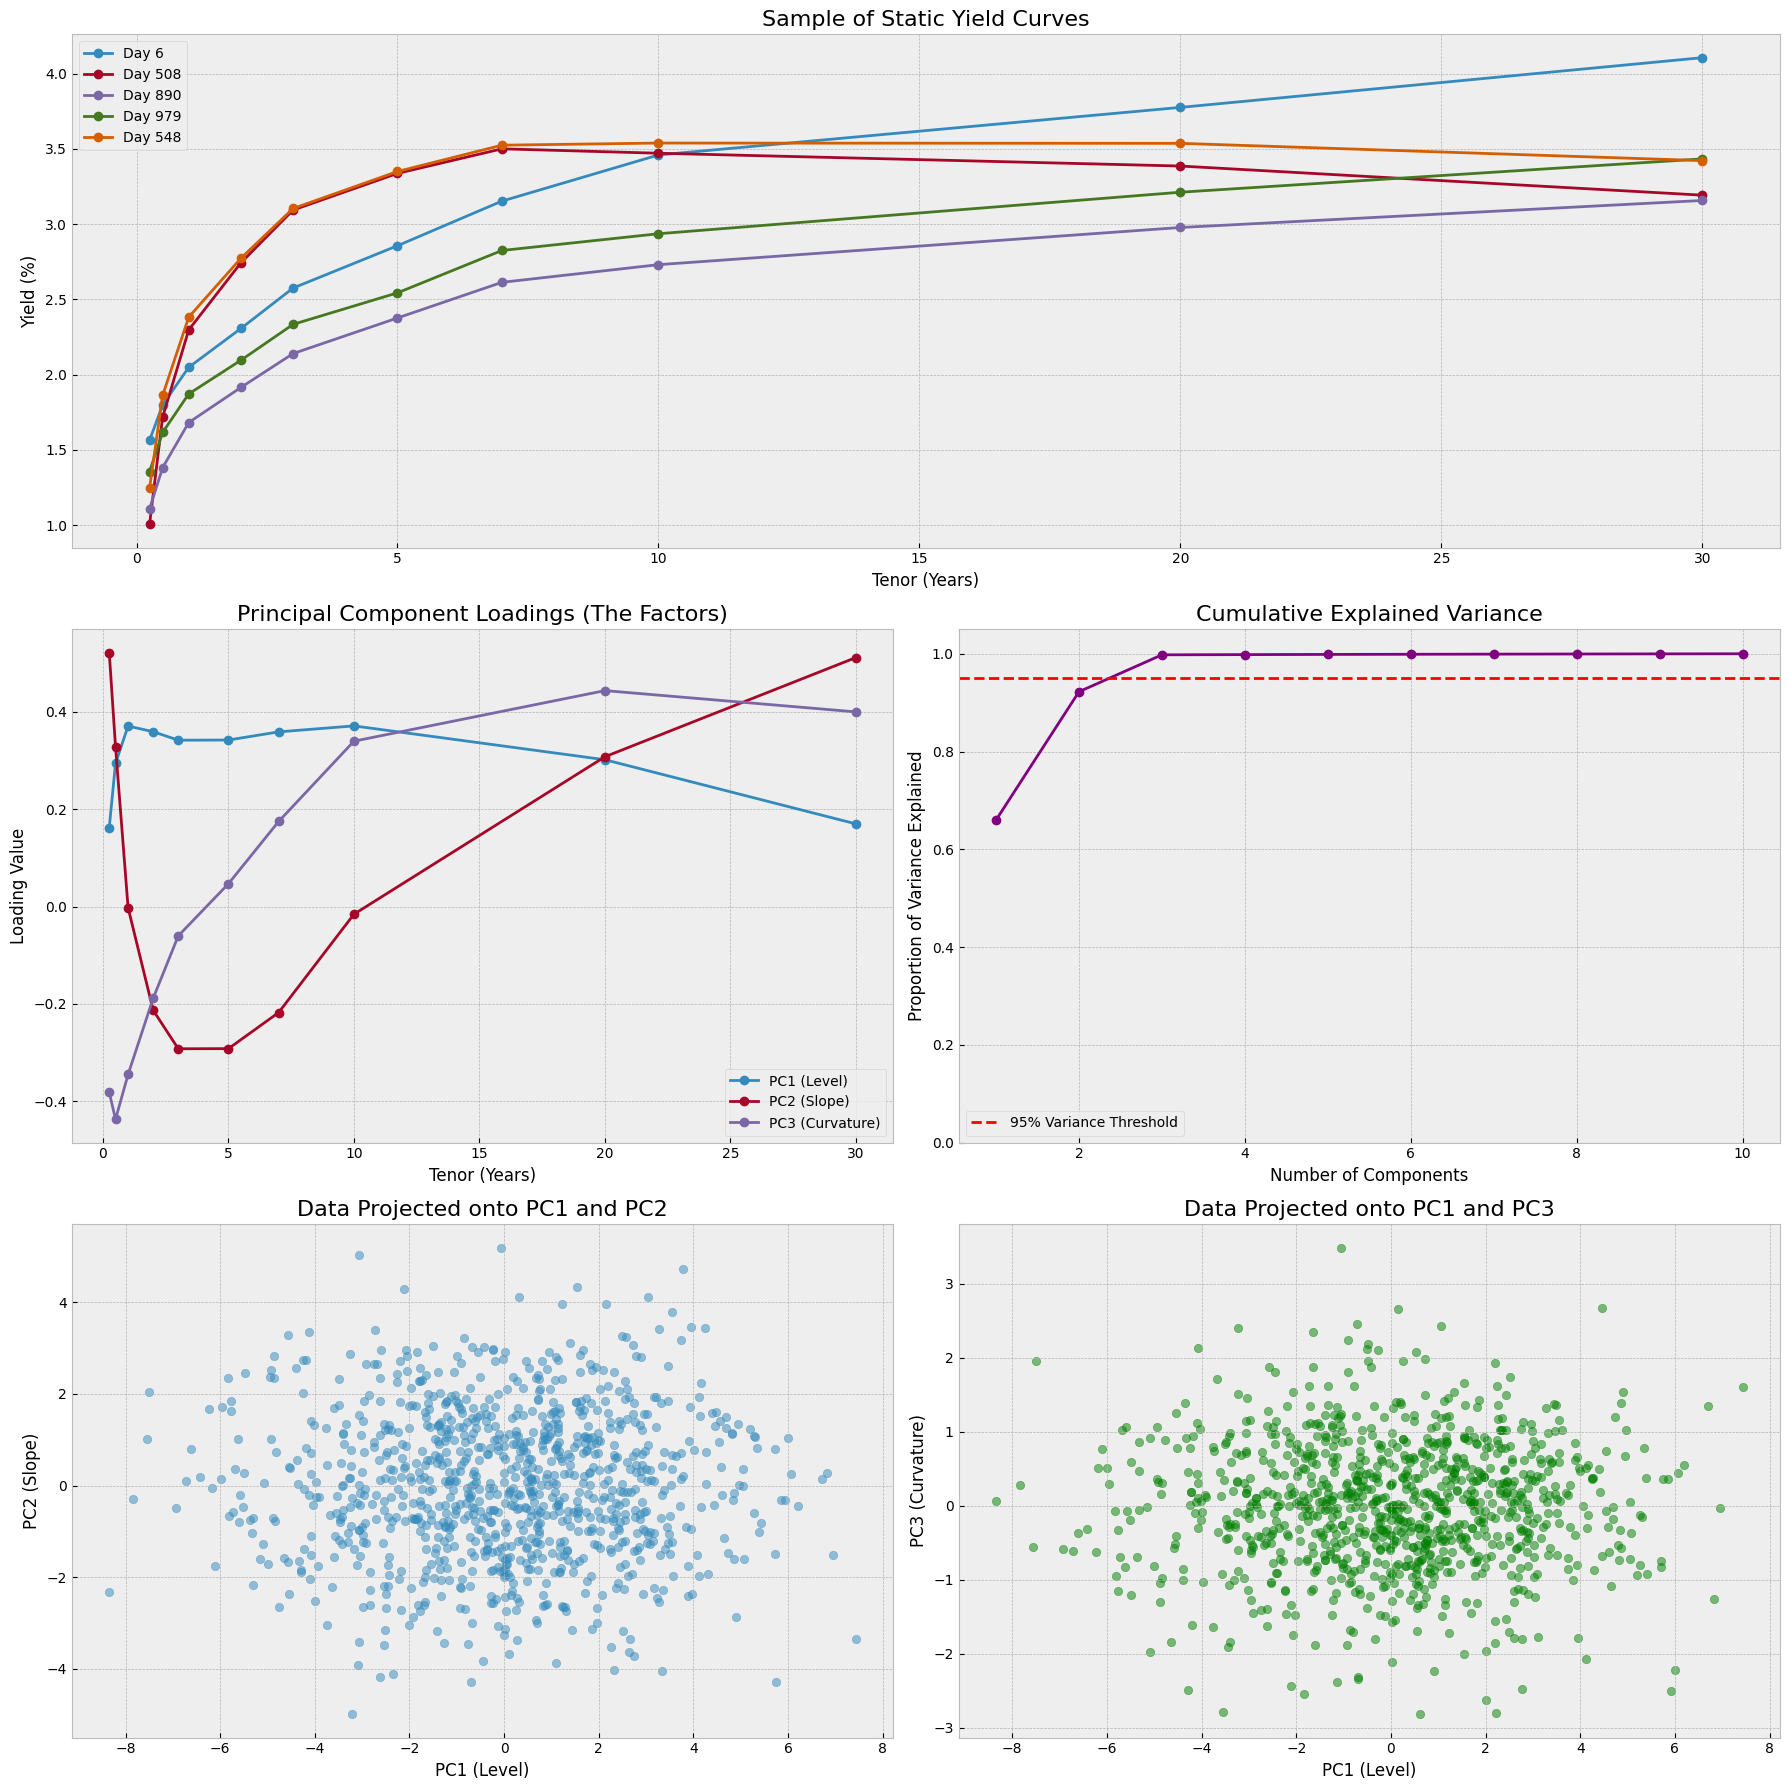

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- 1. Simulate Yield Curve Data ---
# We will simulate daily changes in a 10-tenor yield curve.
# The key is to generate data that has the known properties of yield curve movements:
# 1. Level: All rates tend to move up or down together (dominant effect).
# 2. Slope: Short-term and long-term rates move in opposite directions.
# 3. Curvature: The middle of the curve moves relative to the ends.

# Define the tenors (maturities) of our yield curve in years
tenors = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
n_tenors = len(tenors)
n_samples = 1000 # Number of simulated trading days

# Generate random shocks for the underlying factors
# The standard deviation determines the magnitude of each factor's influence.
level_shocks = np.random.normal(0, 1.5, n_samples)
slope_shocks = np.random.normal(0, 0.8, n_samples)
curvature_shocks = np.random.normal(0, 3, n_samples) # Increased magnitude for visibility

# Create the effect of each factor on the tenors
# Level: A constant effect across all tenors
level_effect = np.ones(n_tenors)
# Slope: A linearly increasing effect from short to long tenors
slope_effect = np.linspace(-1, 1, n_tenors)
# Curvature: A "bow" or "butterfly" effect, high at the ends, low in the middle
curvature_effect = slope_effect**2 - np.mean(slope_effect**2)

# Combine the shocks and effects to create the yield curve changes
# Each day's change is a weighted sum of the three factor shocks plus some noise
yield_curve_changes = (
    level_shocks[:, np.newaxis] * level_effect +
    slope_shocks[:, np.newaxis] * slope_effect +
    curvature_shocks[:, np.newaxis] * curvature_effect +
    np.random.normal(0, 0.1, (n_samples, n_tenors)) # Add idiosyncratic noise
)

# It's standard practice to scale the data before PCA
# We perform PCA on the *changes*, not the absolute levels.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(yield_curve_changes)


# --- 2. Perform PCA ---
# Initialize PCA to find all components
pca = PCA(n_components=n_tenors)
# Fit PCA on the scaled data
X_pca = pca.fit_transform(X_scaled)


# --- 3. Analyze and Print PCA Results ---
explained_variance = pca.explained_variance_ratio_
print("--- Explained Variance by Component---")
for i, variance in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {variance:.4f} ({variance*100:.2f}%)")
print("-" * 35)
print(f"Total variance explained by first 3 components: {np.sum(explained_variance[:3])*100:.2f}%\n")


# --- 4. Visualize the Results ---
fig = plt.figure(figsize=(18, 18))
# Use a 3x2 grid to accommodate the new plot
gs = fig.add_gridspec(3, 2)

# --- NEW PLOT: Static Yield Curves on a Handful of Days ---
ax0 = fig.add_subplot(gs[0, :]) # New plot spans the entire top row
# Create a base yield curve and add the cumulative changes to get absolute levels
initial_curve = np.linspace(1.5, 4.0, n_tenors) # A plausible starting curve
absolute_yield_curves = initial_curve + np.cumsum(yield_curve_changes / 100, axis=0) # Divide by 100 to make changes smaller (basis points)

# Select 5 random days to plot
random_days = np.random.choice(n_samples, size=5, replace=False)
for day in random_days:
    ax0.plot(tenors, absolute_yield_curves[day, :], marker='o', linestyle='-', label=f'Day {day}')

ax0.set_title('Sample of Static Yield Curves', fontsize=16)
ax0.set_xlabel('Tenor (Years)', fontsize=12)
ax0.set_ylabel('Yield (%)', fontsize=12)
ax0.legend()
ax0.grid(True)


# Plot 1: Loadings for the first three components (Level, Slope, Curvature)
ax1 = fig.add_subplot(gs[1, 0])
loadings = pca.components_
ax1.plot(tenors, loadings[0], marker='o', linestyle='-', label='PC1 (Level)')
ax1.plot(tenors, loadings[1], marker='o', linestyle='-', label='PC2 (Slope)')
ax1.plot(tenors, loadings[2], marker='o', linestyle='-', label='PC3 (Curvature)')
ax1.set_title('Principal Component Loadings (The Factors)', fontsize=16)
ax1.set_xlabel('Tenor (Years)', fontsize=12)
ax1.set_ylabel('Loading Value', fontsize=12)
ax1.legend()
ax1.grid(True)

# Plot 2: Cumulative Explained Variance
ax2 = fig.add_subplot(gs[1, 1])
cumulative_variance = np.cumsum(explained_variance)
ax2.plot(range(1, n_tenors + 1), cumulative_variance, marker='o', linestyle='-', color='purple')
ax2.axhline(y=0.95, linestyle='--', color='r', label='95% Variance Threshold')
ax2.set_title('Cumulative Explained Variance', fontsize=16)
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Proportion of Variance Explained', fontsize=12)
ax2.set_ylim(0, 1.05)
ax2.legend()
ax2.grid(True)

# Plot 3 & 4: Projections onto component pairs
# PC1 vs PC2
ax3 = fig.add_subplot(gs[2, 0])
ax3.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
ax3.set_title('Data Projected onto PC1 and PC2', fontsize=16)
ax3.set_xlabel('PC1 (Level)', fontsize=12)
ax3.set_ylabel('PC2 (Slope)', fontsize=12)
ax3.grid(True)

# PC1 vs PC3
ax4 = fig.add_subplot(gs[2, 1])
ax4.scatter(X_pca[:, 0], X_pca[:, 2], alpha=0.5, color='green')
ax4.set_title('Data Projected onto PC1 and PC3', fontsize=16)
ax4.set_xlabel('PC1 (Level)', fontsize=12)
ax4.set_ylabel('PC3 (Curvature)', fontsize=12)
ax4.grid(True)


plt.tight_layout()
plt.show()

#### Trees

Trees are good for classification and regression problems, and are a staple of machine learning. They work like a flowchart, where we ask a bunch of questions about the data, and then make a decision based on the answers. However, also like a flowchart, we can ask a *different* series of questions, depending on our previous answers.

The way that we can construct a tree is that we loop through each feature, and then each *split* of that feature, and then we want to find the split that minimizes our prediction error.

So, let's say we have a dataset with a single feature:

`[1,1,1,1,2,3]`

And our target variable is:

`[0,0,0,1,2,1]`

Then, one split we could make is "less than 3". We now have 2 groups:
- Group 1: `[1,1,1,1,2]` with target `[0,0,0,1,2]`
- Group 2: `[3]` with target `[1]`

Note that the prediction of our tree is going to be the *mean* of the target variable in each group. So, for Group 1, the mean is `(0+0+0+1+2)/5 = 0.6`, and for Group 2, the mean is `1`. Therefore, our residual sum of squares (RSS) for this split is:
- Group 1: `(0-0.6)^2 + (0-0.6)^2 + (0-0.6)^2 + (1-0.6)^2 + (2-0.6)^2 = 0.36 + 0.36 + 0.36 + 0.16 + 1.96 = 3.2`
- Group 2: `(1-1)^2 = 0`
For a total RSS of `3.2`.

Nice, so now lets check a different split, say "less than 2". We now have:
- Group 1: `[1,1,1,1]` with target `[0,0,0,1]`
- Group 2: `[2,3]` with target `[2,1]`
Our predictions are now:
- Group 1: `(0+0+0+1)/4 = 0.25`
- Group 2: `(2+1)/2 = 1.5`

So our residual sum of squares (RSS) for this split is:
- Group 1: `(0-0.25)^2 + (0-0.25)^2 + (0-0.25)^2 + (1-0.25)^2 = 0.0625 + 0.0625 + 0.0625 + 0.5625 = 0.75`
- Group 2: `(2-1.5)^2 + (1-1.5)^2 = 0.25 + 0.25 = 0.5`

So the total RSS for this split is `0.75 + 0.5 = 1.25`, which is much better than the previous split.

We can keep doing this for each feature, and each split, until we find a split that minimizes our RSS.

Note that for classification trees, we can just do "voting", where we take the most common class in each group, instead of the mean.

What might be some problems with this approach?

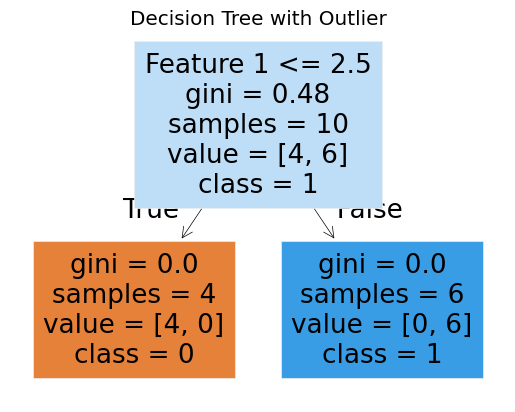

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import numpy as np

import matplotlib.pyplot as plt

# Create synthetic data with 2 features and an outlier
X = np.array([
    [1, 2], [2, 1], [1.5, 1.8], [2, 2.2], [3, 3], [3.2, 2.8], [3, 4], [4, 3.5], [4.5, 4.2], [5, 5],
    # [10, 10]  # outlier
])
y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ])  

# Fit a decision tree
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X, y)

# Plot the tree
plot_tree(tree, feature_names=['Feature 1', 'Feature 2'], class_names=['0', '1'], filled=True)
plt.title("Decision Tree with Outlier")
plt.show()

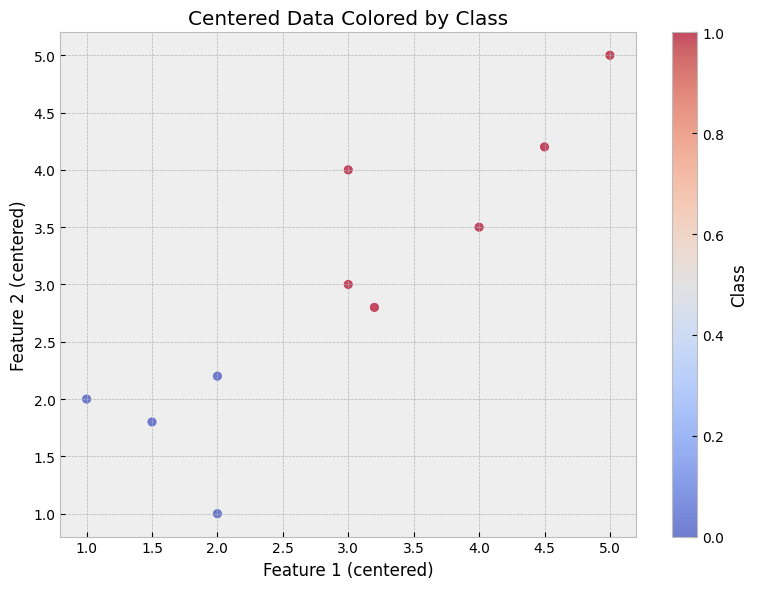

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.xlabel('Feature 1 (centered)')
plt.ylabel('Feature 2 (centered)')
plt.title('Centered Data Colored by Class')
plt.colorbar(label='Class')
plt.tight_layout()
plt.show()

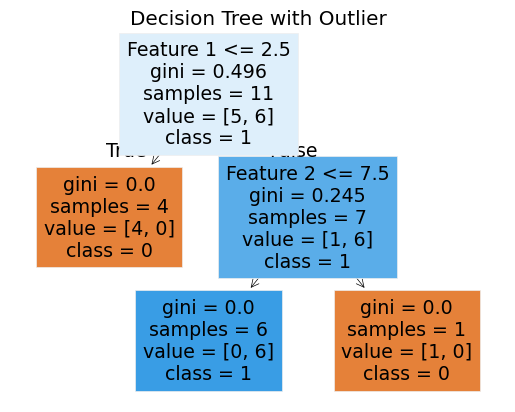

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import numpy as np

import matplotlib.pyplot as plt

# Create synthetic data with 2 features and an outlier
X = np.array([
    [1, 2], [2, 1], [1.5, 1.8], [2, 2.2], [3, 3], [3.2, 2.8], [3, 4], [4, 3.5], [4.5, 4.2], [5, 5],
    [10, 10]  # outlier
])
y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0])  

# Fit a decision tree
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X, y)

# Plot the tree
plot_tree(tree, feature_names=['Feature 1', 'Feature 2'], class_names=['0', '1'], filled=True)
plt.title("Decision Tree with Outlier")
plt.show()

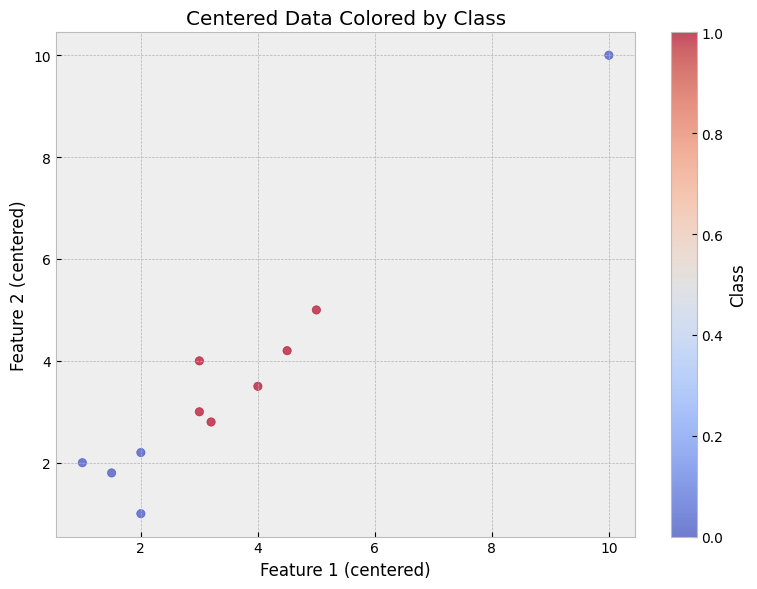

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.xlabel('Feature 1 (centered)')
plt.ylabel('Feature 2 (centered)')
plt.title('Centered Data Colored by Class')
plt.colorbar(label='Class')
plt.tight_layout()
plt.show()

The *big* issue with trees (aside from computation :), but who cares about that these days) is that they can be very sensitive to overfitting. That is, if we keep splitting the data repeatedly, we can end up with a tree that might perfectly fit the training data, but then performs poorly out of sample. We might also end up with a very deep tree (lots of decision points), which can potentially lead to instability or overfitting.

This is much more severe than something like linear regression, where the data sort of "balances" out any outliers (ish), whereas with a tree, since we're directly partitioning the data, we increase this risk.

There are a few easy ways to get around this, such as:
- Pruning, which means we just remove some of the splits that don't really help us.
- Setting a maximum depth, which means that we stop splitting the data after a certain number of splits.
- Setting a minimum number of samples per node, to ensure that we don't split the data too much.

However, even with these techniques, we can still end up with a high variance model.

#### Bagging (Bootstrap Aggregating)

This is a very nice way to reduce the variance of our model, and make it more stable, even if the individual trees themselves are not stable. The idea is that we can "bootstrap" our data (take random samples of it), fit each tree to each sample, and then "aggregate" the predictions of each tree to get a final prediction.

So, if we split out data into `B` samples, our final model is:
$$
\hat{y} = \frac{1}{B} \sum_{b=1}^{B} \hat{y}_b
$$

For instance, if I have 2 trees, and they predict `0.6` and `0.8`, then my final prediction is `(0.6 + 0.8)/2 = 0.7`.

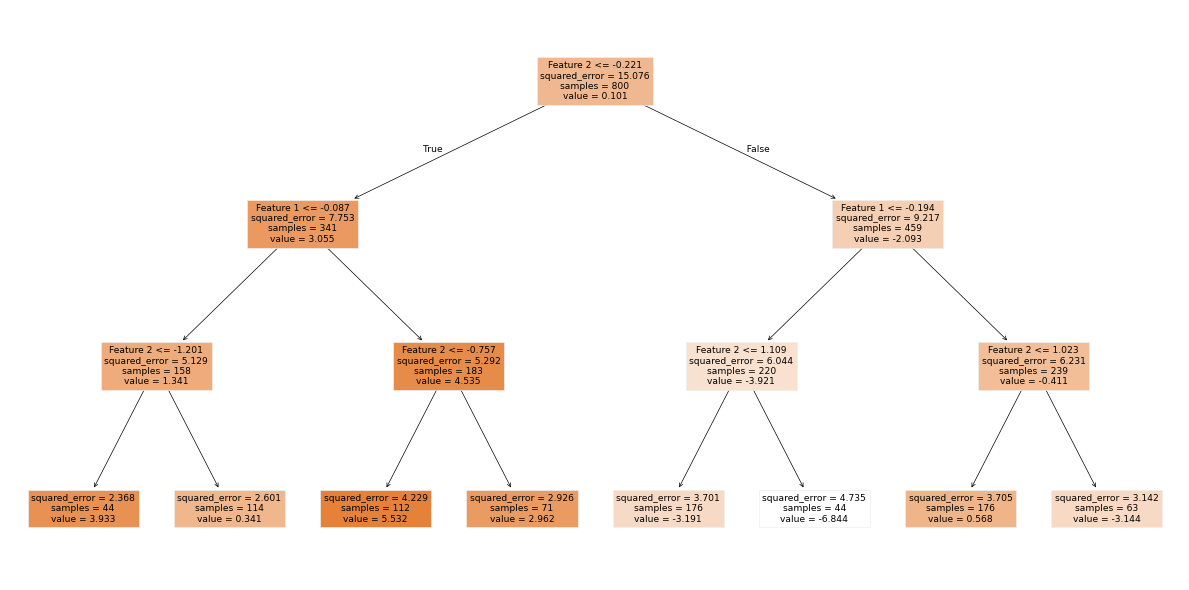

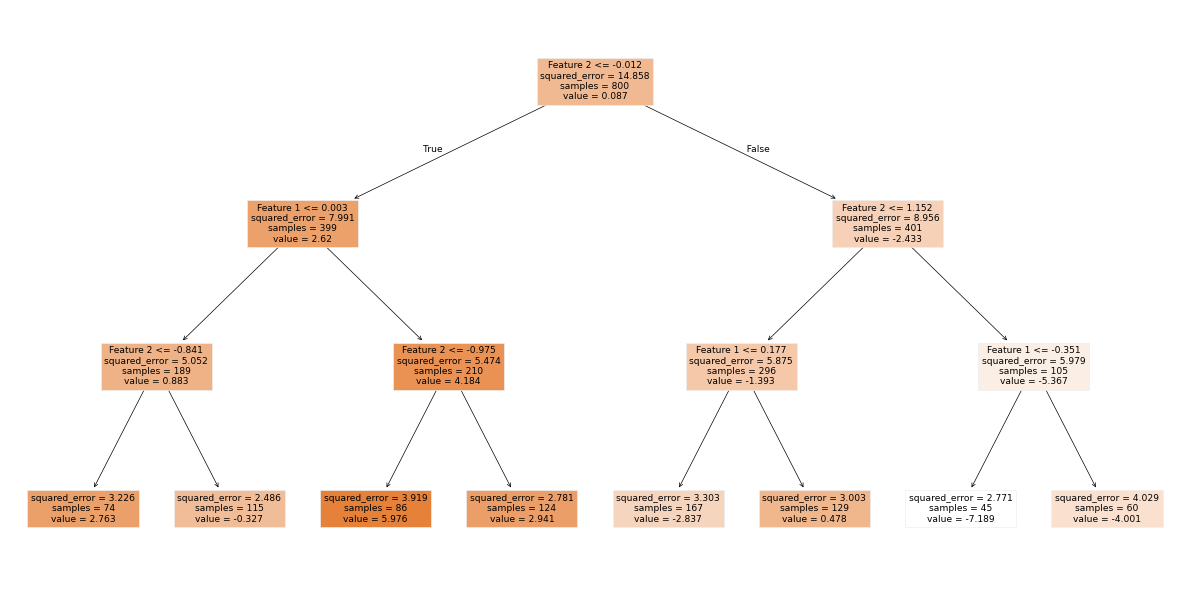

Tree 1 Test RSS: 1867.25
Tree 2 Test RSS: 1597.92


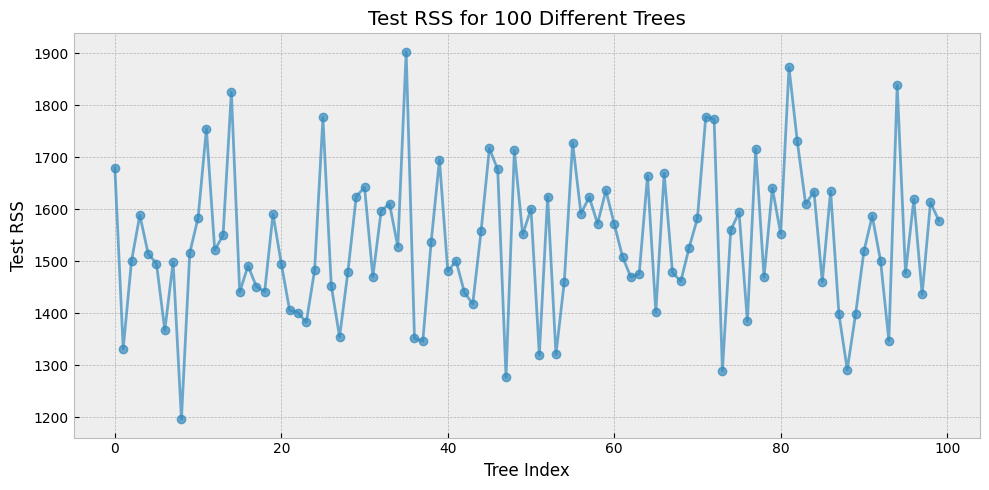

Average of 100 Trees Test RSS: 798.58


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
import numpy as np

import matplotlib.pyplot as plt

# Generate synthetic data with 5 features
np.random.seed(42)
X = np.random.randn(2000, 3)
y = 2*X[:, 0] - 3*X[:, 1] + 0.5*X[:, 2] + np.random.randn(2000)  # some linear-ish target

# Split into 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Fit two individual trees with different random states
tree1 = DecisionTreeRegressor(max_depth=3, random_state=0)
tree2 = DecisionTreeRegressor(max_depth=3, random_state=1)

# Randomly select half the training data for each tree
np.random.seed(0)
indices1 = np.random.choice(len(X_train), size=len(X_train)//2, replace=False)
np.random.seed(1)
indices2 = np.random.choice(len(X_train), size=len(X_train)//2, replace=False)

tree1.fit(X_train[indices1], y_train[indices1])
tree2.fit(X_train[indices2], y_train[indices2])

# Plot the two trees
plt.figure(figsize=(12, 6))
plot_tree(tree1, feature_names=[f'Feature {i+1}' for i in range(3)], filled=True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plot_tree(tree2, feature_names=[f'Feature {i+1}' for i in range(5)], filled=True)
plt.tight_layout()
plt.show()

# Calculate out-of-sample RSS for both trees
y_pred1 = tree1.predict(X_test)
y_pred2 = tree2.predict(X_test)
rss1 = np.sum((y_test - y_pred1) ** 2)
rss2 = np.sum((y_test - y_pred2) ** 2)
print(f"Tree 1 Test RSS: {rss1:.2f}")
print(f"Tree 2 Test RSS: {rss2:.2f}")

# Iteratively fit 100 trees and collect their test RSS
rss_list = []
tree_list = []
for i in range(100):
    tree = DecisionTreeRegressor(max_depth=4, random_state=i)
    # Randomly select 10% of the training data
    np.random.seed(i)
    indices = np.random.choice(len(X_train), size=len(X_train)//10, replace=False)
    X_sample, y_sample = X_train[indices], y_train[indices]
    tree.fit(X_sample, y_sample)
    y_pred = tree.predict(X_test)
    rss = np.sum((y_test - y_pred) ** 2)
    rss_list.append(rss)
    tree_list.append(tree)

plt.figure(figsize=(10, 5))
plt.plot(rss_list, marker='o', linestyle='-', alpha=0.7)
plt.xlabel('Tree Index')
plt.ylabel('Test RSS')
plt.title('Test RSS for 100 Different Trees')
plt.tight_layout()
plt.show()

# Now predict using the average of all trees
y_preds = np.array([tree.predict(X_test) for tree in tree_list])
y_pred_avg = np.mean(y_preds, axis=0)
rss_avg = np.sum((y_test - y_pred_avg) ** 2)
print(f"Average of 100 Trees Test RSS: {rss_avg:.2f}")

Note that the *lowest* RSS across any individual tree was about ~1200. But, for the bagged model, we got an RSS of about ~800! Additionally, the predictions are much more stable.

So, that works pretty well. But, what happens if the data has a lot of features, a subset of them are the most important, but an important minority still matter? Then, we might run the risk of *all* of our trees using the same features, meaning that we don't get the full benefit of bagging. 

Specifically, let's say that we have 10 features, and 2 of them are the most important. Then, we might end up with all of our trees only using those 2 features, and ignoring the other 8. This is bad since there still might be important information in those other features, and we aren't using it!

So, what we really want for variance reduction is to have *uncorrelated* trees. Meaning that if one tree makes a mistake, the other trees might not make the same mistake, and therefore we can "average out" the errors.

#### Random Forests

The only difference between bagging and random forests is that when we fit each tree, not only do we randomly sample the data, but we also randomly sample the features. Meaning that we're forced to use trees that "look" at different aspects of the data, which helps us to reduce the correlation between the trees, and therefore reduce the variance of the final model.

Note that this variance reduction matters a *lot* when you're continually retraining your model (the real world), since you want your model to be stable and not drastically change every time you retrain it.

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Fit a random forest with 100 trees
rf = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Calculate out-of-sample RSS for the random forest
rss_rf = np.sum((y_test - y_pred_rf) ** 2)
print(f"Random Forest (100 trees) Test RSS: {rss_rf:.2f}")

Random Forest (100 trees) Test RSS: 883.11


#### What if my model is just bad?

If you model is bad, then it means it probably has high bias, meaning that it doesn't fit the data well. However, we can boost the performance of our model by, you guessed it, boosting!

So, just how Bagging targets variance reduction, Boosting targets bias reduction.

/Users/tobiasdelpozo/Documents/School/5th_Year_MSFM/August_Review/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


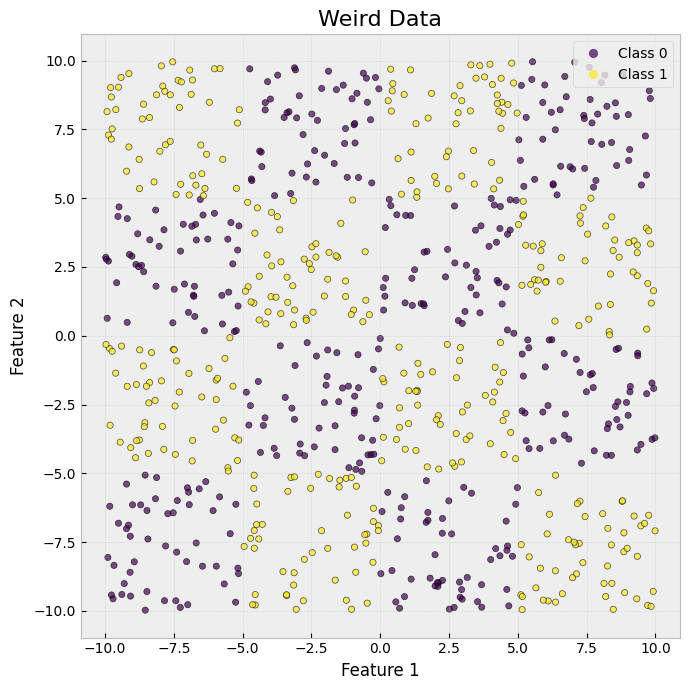

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Set a random seed for reproducibility
np.random.seed(42)

# --- 1. Generate a more complex 4x4 Checkerboard Dataset ---
n_points_per_square = 50
grid_size = 4
limit = 10 # The grid will go from -limit to +limit
step = (limit * 2) / grid_size

all_points = []
all_labels = []

# Loop through the 4x4 grid
for i in range(grid_size):
    for j in range(grid_size):
        # Determine the class based on grid position (i+j)
        label = (i + j) % 2
        
        # Define the boundaries of the current square
        x_min = -limit + i * step
        x_max = -limit + (i + 1) * step
        y_min = -limit + j * step
        y_max = -limit + (j + 1) * step
        
        # Generate random points within this square
        points_x = np.random.uniform(x_min, x_max, n_points_per_square)
        points_y = np.random.uniform(y_min, y_max, n_points_per_square)
        
        all_points.append(np.vstack((points_x, points_y)).T)
        all_labels.extend([label] * n_points_per_square)

# Combine all points and labels
X = np.vstack(all_points)
y = np.array(all_labels)

# Create a DataFrame for easier use
df = pd.DataFrame(X, columns=['feature1', 'feature2'])
df['target'] = y


# --- 2. Fit a Decision Tree that will UNDERFIT the complex data ---
# Even with a depth of 5, the tree cannot perfectly capture the 4x4 pattern.
# This is a high-bias model relative to the complexity of the data.

# Make this a random forest
from sklearn.ensemble import RandomForestClassifier

tree = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
tree.fit(df[['feature1', 'feature2']], df['target'])

# Predict on the training data
y_pred_tree = tree.predict(df[['feature1', 'feature2']])

# Compute the accuracy
accuracy_tree = accuracy_score(df['target'], y_pred_tree)
# --- 3. Visualize the Data and the Underfit Decision Boundary ---
plt.figure(figsize=(7, 7))
# Plot the data points
scatter = plt.scatter(df['feature1'], df['feature2'], c=df['target'], cmap='viridis', alpha=0.7, edgecolors='k', s=20)

# Create a meshgrid to plot the decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 200),
                     np.linspace(ylim[0], ylim[1], 200))
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
# plt.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')

plt.title('Weird Data', fontsize=16)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.grid(True, linestyle=':', alpha=0.6)
plt.axis('equal')
plt.tight_layout()
plt.show()


Thhe data structure is kind of obvious right? So lets fit a tree to it:

Decision Tree: 0.77


/Users/tobiasdelpozo/Documents/School/5th_Year_MSFM/August_Review/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


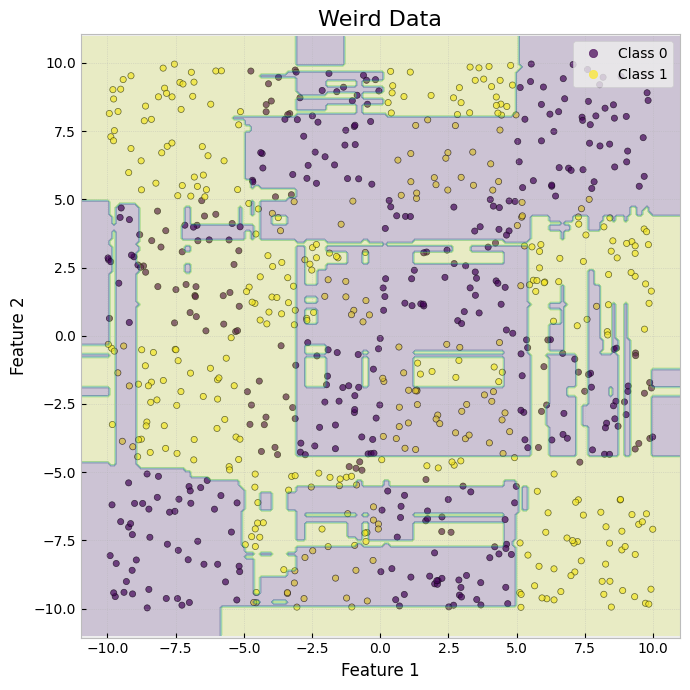

In [13]:
plt.figure(figsize=(7, 7))
# Plot the data points
scatter = plt.scatter(df['feature1'], df['feature2'], c=df['target'], cmap='viridis', alpha=0.7, edgecolors='k', s=20)

# Print accuracy
print(f"Decision Tree: {accuracy_tree:.2f}")

# Create a meshgrid to plot the decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 200),
                     np.linspace(ylim[0], ylim[1], 200))
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')

plt.title('Weird Data', fontsize=16)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.grid(True, linestyle=':', alpha=0.6)
plt.axis('equal')
plt.tight_layout()
plt.show()

Uh, what? The tree is certainly not capturing the complexity of the data and is definitely overfitting. I admit that I capped the max depth, but in real life you probably want to as well -- because how do we know if we're overfit or not!

#### Boosting

Boosting is a technique that lets us reduce bias by taking a bunch of bad models, and combining them to make a better model. Each bad model might be only slightly better than random, but if we combine them, we can get a model that is much better than random.

Note that in these examples I'm normalizing for the number of total "nodes"-ish. So a random forest with 100 trees and a max depth of 3, I'm going to compare to a boosted tree with a max depth of 3 and ~10 trees.

The *core* idea of boosting is that we fit a model to the data, and then use the errors of that model to fit a model which "corrects" the errors of the previous one, and repeat the process. 

We're going to be going over 2 examples of boosting: AdaBoost and Gradient Boosting.

#### AdaBoost (Adaptive Boosting)

This is an example of the algorithm for AdaBoost (Adaptive Boosting):

Step 1: Weigh the data equally ($w_i = 1/n$) and fit your first tree. This tree will make a lot of mistakes.

Step 2: Calculate how much we care about the performance of the first tree. If the first tree does really well, then we want to update the data weights to "shore up" those errors. 

We might do something like $w_i \gets w_i e^{\alpha I(y_i \neq f(x_i))}$, where $\alpha$ is the weight of the classifier, $y_i$ is the true label, and $f(x_i)$ is the predicted label. 

This means that:
1. If the prediction is correct, the weight stays the same (or, you could decrease it by having the indicator evaluate to -1).
    1. If the prediction is correct, but the model was bad, then decrease the weight by a little bit (small $\alpha$, we think it was due to chance).
    2. If the prediction is correct, but the model was really good, decrease the weight by a lot. The reason for this is that we're able to already make a good prediction using our first tree, so we don't need to focus subsequent trees on that data point.
2. If the prediction is incorrect, the importance of that data point increases. 
    1. If the prediction is incorrect, but the model was really bad, then we might not want to increase the weight too much, so we can use a small $\alpha$ (eg. we think it was a fluke).
    2. If the prediction is incorrect, but the model was really good, then we might want to increase the weight a lot, so we can use a large $\alpha$ (eg. we think it was the model's fault).

Step 3: Fit another tree to the data, using updated weights. This tree will focus on the data points that the first tree got wrong, and try to correct them.

Step 4: Repeat step 2 and 3 (upweight, downweight, fit tree), until you reach your maximum number of trees, or until the performance stops improving.

Note that there are a lot of variations of this algorithm. For instance, lets say you want to instead use a bunch of linear regressions, each of which are trained on different features. Then, you at each step, instead of just fitting the next tree, you would pick the linear regression that minimizes the error of the (weighted) data.

AdaBoost with 8 Trees (max_depth=3) Accuracy: 0.820


/Users/tobiasdelpozo/Documents/School/5th_Year_MSFM/August_Review/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


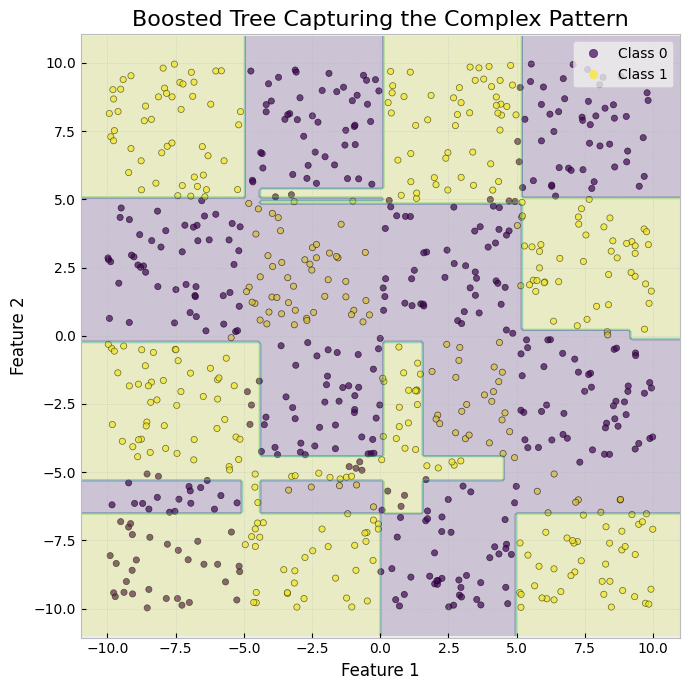

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Set a random seed for reproducibility
np.random.seed(42)

# --- 1. Generate the same complex 4x4 Checkerboard Dataset ---
n_points_per_square = 50
grid_size = 4
limit = 10 # The grid will go from -limit to +limit
step = (limit * 2) / grid_size

all_points = []
all_labels = []

# Loop through the 4x4 grid
for i in range(grid_size):
    for j in range(grid_size):
        label = (i + j) % 2
        x_min, x_max = -limit + i * step, -limit + (i + 1) * step
        y_min, y_max = -limit + j * step, -limit + (j + 1) * step
        points_x = np.random.uniform(x_min, x_max, n_points_per_square)
        points_y = np.random.uniform(y_min, y_max, n_points_per_square)
        all_points.append(np.vstack((points_x, points_y)).T)
        all_labels.extend([label] * n_points_per_square)

X = np.vstack(all_points)
y = np.array(all_labels)
df = pd.DataFrame(X, columns=['feature1', 'feature2'])
df['target'] = y


# --- 3. Fit the AdaBoost Classifier ---
# We use the same tree as our "base estimator".
# AdaBoost will create a sequence of these trees, each one focusing
# on the errors of the previous ones.
ada_boost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
    n_estimators=8,       # The number of trees to build in sequence
    learning_rate=1.0,
    random_state=42
)
ada_boost.fit(df[['feature1', 'feature2']], df['target'])

# Predict with the boosted model
y_pred_boost = ada_boost.predict(df[['feature1', 'feature2']])

# Compute the accuracy of the boosted model
accuracy_boost = accuracy_score(df['target'], y_pred_boost)
print(f"AdaBoost with 8 Trees (max_depth=3) Accuracy: {accuracy_boost:.3f}")


# --- 4. Visualize the Final Boosted Decision Boundary ---
plt.figure(figsize=(7, 7))
# Plot the data points
scatter = plt.scatter(df['feature1'], df['feature2'], c=df['target'], cmap='viridis', alpha=0.7, edgecolors='k', s=20)

# Create a meshgrid to plot the decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 200),
                    np.linspace(ylim[0], ylim[1], 200))
Z = ada_boost.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')

plt.title('Boosted Tree Capturing the Complex Pattern', fontsize=16)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.grid(True, linestyle=':', alpha=0.6)
plt.axis('equal') 
plt.tight_layout()
plt.show()

And if we raise this to 50 trees, we get 100% accuracy.

AdaBoost with 50 Trees (max_depth=3) Accuracy: 1.000


/Users/tobiasdelpozo/Documents/School/5th_Year_MSFM/August_Review/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


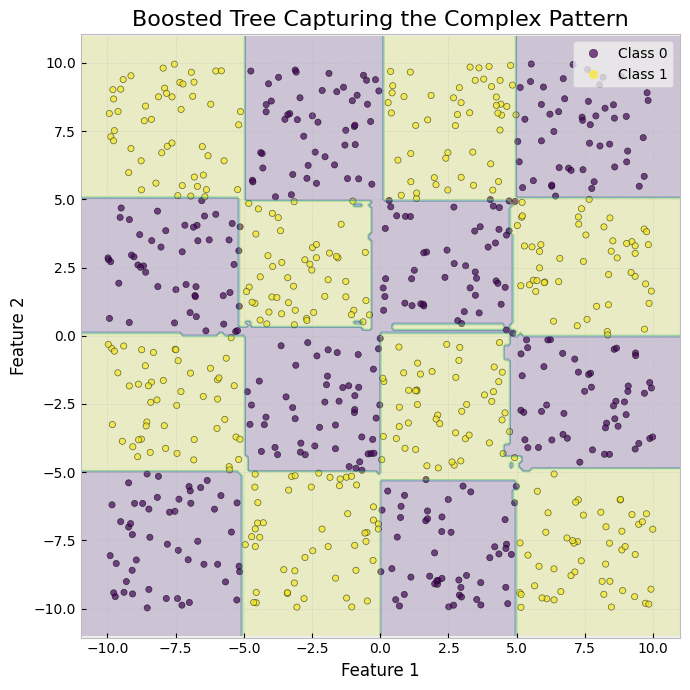

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Set a random seed for reproducibility
np.random.seed(42)

# --- 1. Generate the same complex 4x4 Checkerboard Dataset ---
n_points_per_square = 50
grid_size = 4
limit = 10 # The grid will go from -limit to +limit
step = (limit * 2) / grid_size

all_points = []
all_labels = []

# Loop through the 4x4 grid
for i in range(grid_size):
    for j in range(grid_size):
        label = (i + j) % 2
        x_min, x_max = -limit + i * step, -limit + (i + 1) * step
        y_min, y_max = -limit + j * step, -limit + (j + 1) * step
        points_x = np.random.uniform(x_min, x_max, n_points_per_square)
        points_y = np.random.uniform(y_min, y_max, n_points_per_square)
        all_points.append(np.vstack((points_x, points_y)).T)
        all_labels.extend([label] * n_points_per_square)

X = np.vstack(all_points)
y = np.array(all_labels)
df = pd.DataFrame(X, columns=['feature1', 'feature2'])
df['target'] = y


# --- 3. Fit the AdaBoost Classifier ---
# We use the same tree as our "base estimator".
# AdaBoost will create a sequence of these trees, each one focusing
# on the errors of the previous ones.
ada_boost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
    n_estimators=50,       # The number of trees to build in sequence
    learning_rate=1.0,
    random_state=42
)
ada_boost.fit(df[['feature1', 'feature2']], df['target'])

# Predict with the boosted model
y_pred_boost = ada_boost.predict(df[['feature1', 'feature2']])

# Compute the accuracy of the boosted model
accuracy_boost = accuracy_score(df['target'], y_pred_boost)
print(f"AdaBoost with 50 Trees (max_depth=3) Accuracy: {accuracy_boost:.3f}")

# --- 4. Visualize the Final Boosted Decision Boundary ---
plt.figure(figsize=(7, 7))
# Plot the data points
scatter = plt.scatter(df['feature1'], df['feature2'], c=df['target'], cmap='viridis', alpha=0.7, edgecolors='k', s=20)

# Create a meshgrid to plot the decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 200),
                     np.linspace(ylim[0], ylim[1], 200))
Z = ada_boost.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')

plt.title('Boosted Tree Capturing the Complex Pattern', fontsize=16)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.grid(True, linestyle=':', alpha=0.6)
plt.axis('equal') 
plt.tight_layout()
plt.show()

Pretty good!

But, note that boosting is a class of algorithms, and AdaBoost is just one of them. 

Maybe a simpler a algorithm is Gradient Boosting, which we can apply to linear regression. The process goes:

1. Fit a model to the data.
2. Calculate the residuals.
3. Fit a new model to the residuals.
4. Add the new model to the previous model.

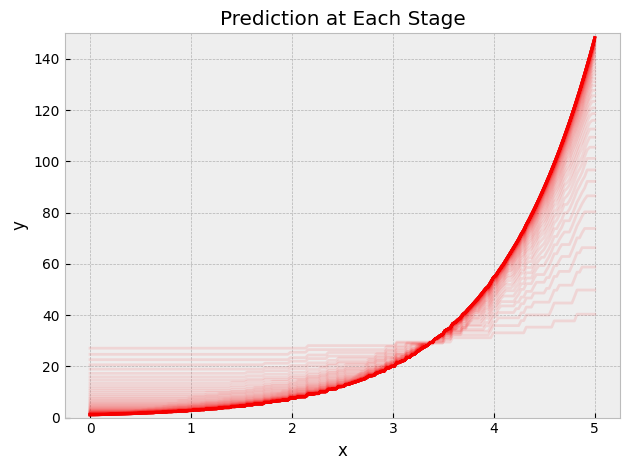

Text(0.5, 1.0, 'MSE vs. Boosting Iterations')

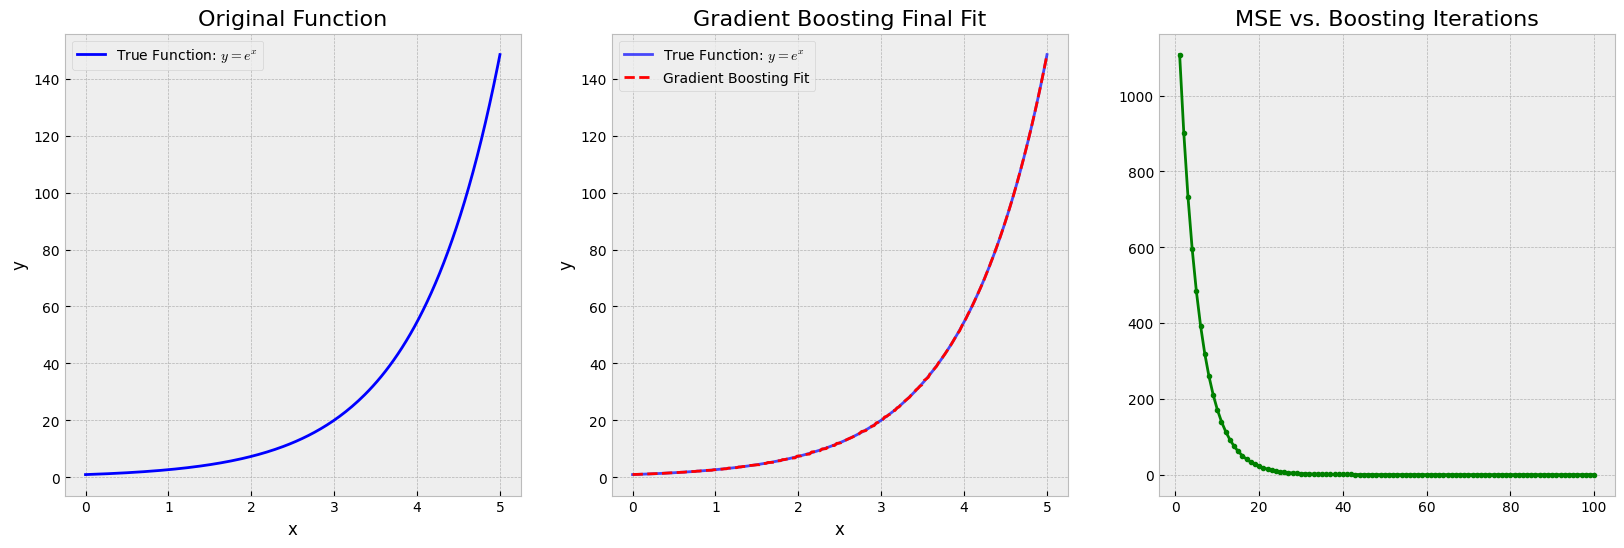

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# 1. Generate the data
# Create 200 data points for x from 0 to 5
x = np.linspace(0, 5, 200)
# Calculate y as e^x
y = np.exp(x)

# Scikit-learn expects X to be a 2D array, so we reshape it
X = x.reshape(-1, 1)

# 2. Configure and train the Gradient Boosting model
# We set the number of boosting stages (trees) to 100
# and the max_depth of each individual tree to 3.
# The learning_rate shrinks the contribution of each tree.
gbr = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    loss='squared_error',
    random_state=42 # for reproducibility
)

# Fit the model to the data
gbr.fit(X, y)

# 3. Track the MSE over each boosting iteration
# The 'staged_predict' method allows us to see the prediction
# at each stage (after each tree is added).
mse_over_time = []
for y_pred_stage in gbr.staged_predict(X):
    mse = mean_squared_error(y, y_pred_stage)
    mse_over_time.append(mse)
    
for y_pred_stage in gbr.staged_predict(X):
    # Plot the predictions at each stage
    plt.plot(x, y_pred_stage, color='red', alpha=0.1)
    
plt.title('Prediction at Each Stage')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 150)
plt.tight_layout()
plt.show()

# Get the final prediction after all 100 trees have been added
y_final_pred = gbr.predict(X)


# 4. Plot the results 
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: The original function
axes[0].plot(x, y, label=r'True Function: $y = e^x$', color='blue', linewidth=2)
axes[0].set_title('Original Function', fontsize=16)
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('y', fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Plot 2: The final fitted model vs. the true function
axes[1].plot(x, y, label=r'True Function: $y = e^x$', color='blue', linewidth=2, alpha=0.7)
axes[1].plot(x, y_final_pred, label='Gradient Boosting Fit', color='red', linestyle='--', linewidth=2)
axes[1].set_title('Gradient Boosting Final Fit', fontsize=16)
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Plot 3: How the Mean Squared Error (MSE) declines over time
axes[2].plot(range(1, 101), mse_over_time, marker='.', linestyle='-', color='green')
axes[2].set_title('MSE vs. Boosting Iterations', fontsize=16)

### Clustering

Clustering is a technique that lets us find groups of in a dataset. It's a bit like PCA, in that it tries to find the "shape" of the data, but instead of trying to reduce the dimensionality, it tries to find the "groups" of the data.

We've already seen some examples of clustering; that's what kNN is! The only difference is that kNN is supervised learning (we know the labels), whereas clustering is unsupervised learning (we don't know the labels). But, the idea is the same: we're trying to find groups of points that are "close" to each other.

#### K-means Clustering

K-means is a popular clustering algorithm. The idea is to randomly initialize `k` centroids, and then iteratively assign each point to the nearest centroid, and update the centroids based on the mean of the points assigned to each centroid. This process is repeated until the centroids no longer change significantly.

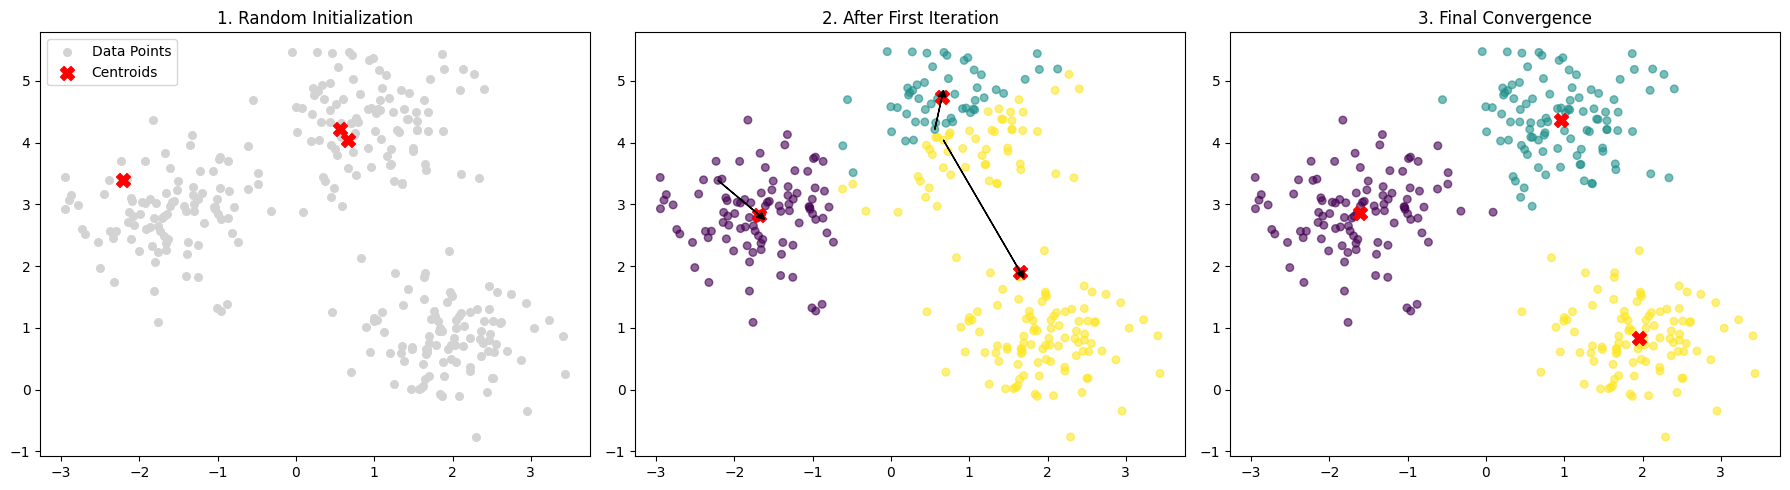

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# --- 1. Generate Data ---
# Creating 3 distinct groups (blobs) in 2D space
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

# --- 2. Helper Functions ---

def assign_clusters(X, centroids):
    # Calculate distance from every point to every centroid
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    # Assign point to the closest centroid index
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    # New centroid is the mean of the points assigned to it
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

# --- 3. K-Means Simulation ---

k = 3
rng = np.random.RandomState(42)

# Step A: Random Initialization
# Pick 3 random points from the dataset to be the initial centroids
initial_indices = rng.permutation(X.shape[0])[:k]
centroids_init = X[initial_indices]

# Step B: First Iteration (Assign & Update)
labels_1 = assign_clusters(X, centroids_init)
centroids_1 = update_centroids(X, labels_1, k)

# Step C: Run until Convergence (Final)
centroids_final = centroids_1
labels_final = labels_1
for _ in range(100): # Max 100 iterations
    prev_centroids = centroids_final
    # Assign
    labels_final = assign_clusters(X, centroids_final)
    # Update
    centroids_final = update_centroids(X, labels_final, k)
    
    # Check if centroids stopped moving
    if np.allclose(prev_centroids, centroids_final):
        break

# --- 4. Plotting the 3 Graphs ---

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Graph 1: Random Initialization
axes[0].scatter(X[:, 0], X[:, 1], c='lightgray', s=30, label='Data Points')
axes[0].scatter(centroids_init[:, 0], centroids_init[:, 1], c='red', s=100, marker='X', label='Centroids')
axes[0].set_title("1. Random Initialization")
axes[0].legend()

# Graph 2: After 1st Iteration
# Points are colored by their first assignment, Centroids have moved once
axes[1].scatter(X[:, 0], X[:, 1], c=labels_1, cmap='viridis', s=30, alpha=0.6)
axes[1].scatter(centroids_1[:, 0], centroids_1[:, 1], c='red', s=100, marker='X', label='Centroids (Updated)')
axes[1].set_title("2. After First Iteration")
# Draw lines from old centroids to new ones to show movement
for i in range(k):
    axes[1].arrow(centroids_init[i, 0], centroids_init[i, 1], 
                  centroids_1[i, 0] - centroids_init[i, 0], 
                  centroids_1[i, 1] - centroids_init[i, 1], 
                  head_width=0.1, head_length=0.1, fc='black', ec='black')

# Graph 3: Final Clusters
axes[2].scatter(X[:, 0], X[:, 1], c=labels_final, cmap='viridis', s=30, alpha=0.6)
axes[2].scatter(centroids_final[:, 0], centroids_final[:, 1], c='red', s=100, marker='X', label='Final Centroids')
axes[2].set_title("3. Final Convergence")

plt.tight_layout()
plt.show()

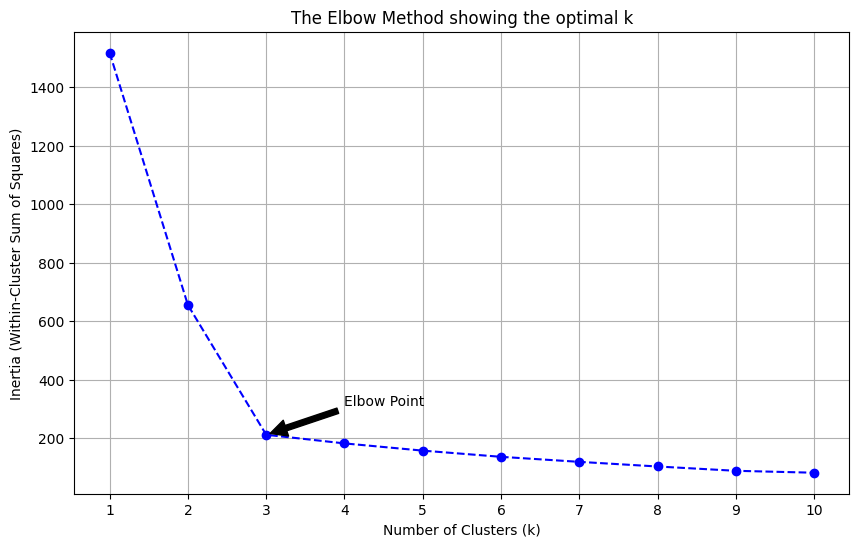

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# --- 1. Generate the same Data ---
# 3 distinct groups
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

# --- 2. Run K-Means for a range of k ---
inertias = []
k_range = range(1, 11)

for k in k_range:
    # We use sklearn's optimized KMeans here for stability
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(X)
    
    # "Inertia" is the sum of squared distances of samples to their closest cluster center
    inertias.append(model.inertia_)

# --- 3. Plot the Elbow Curve ---
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('The Elbow Method showing the optimal k')
plt.xticks(k_range)
plt.grid(True)

# Highlight the "Elbow" at k=3
plt.annotate('Elbow Point', xy=(3, inertias[2]), xytext=(4, inertias[2] + 100),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

#### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

With some algorithms, we don't need to specify the number of clusters in advance. DBSCAN is one such algorithm. It works by identifying dense regions of the data and grouping points that are "close" to each other. Points that are not part of any dense region are considered noise.

The way DBSCAN works is by defining two parameters:
- $\epsilon$ (eps): The maximum distance between two points for them to be considered as in the same neighborhood.
- MinPts: The minimum number of points required to form a dense region.

We then are going to classify each point as:
- Core point: A point that has at least `MinPts` points within a distance of $\epsilon$. We can think of these points as the "center" of a cluster.
- Border point: A point that is not a core point, but is within a distance of $\epsilon$ of a core point.
- Noise: A point that is neither a core point nor a border point.

The algorithm for this procedure is:

1. Pick a random point $P$.
2. Count how many points are within a distance of $\epsilon$ of $P$.
    1. If there are at least `MinPts` points within $\epsilon$, then $P$ is a core point.
    2. Otherwise, $P$ is a noise point (for now).
3. If $P$ is a core point, then we're going to classify all of the points within a distance of $\epsilon$ of $P$ as part of the same cluster. We cna think of this as a "fire" that starts at $P$ and spreads to all of the points within $\epsilon$ of $P$. If a given neighbor (new point) is also a core point, then we continue the "fire" to all of its neighbors. If a given neighbor is not a core point, but is within $\epsilon$ of a core point, then we classify it as a border point.
4. We repeat this process (starting at 1) for all unvisited points until all points have been classified as either core, border, or noise.

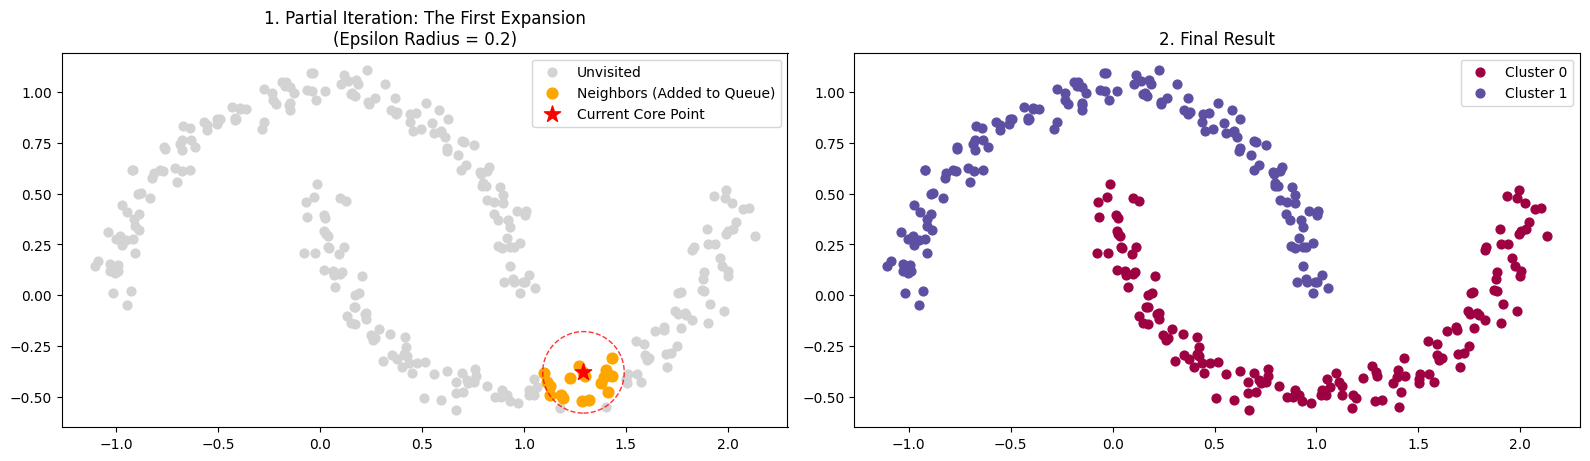

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

# --- 1. Generate Data (The "Moons" dataset) ---
# Noise=0.05 adds a little bit of scramble to make it realistic
X, y_true = make_moons(n_samples=300, noise=0.05, random_state=42)

# --- Parameters ---
EPSILON = 0.2
MIN_SAMPLES = 5

# --- 2. Simulation for Graph 1: "The First Spark" ---
# Let's pick a specific point to start the "fire" (cluster expansion)
start_index = 10  # Arbitrary point in the top moon
start_point = X[start_index]

# Manually find neighbors to visualize the "Check Neighborhood" step
distances = np.linalg.norm(X - start_point, axis=1)
neighbor_indices = np.where(distances < EPSILON)[0]

# --- 3. Run Full DBSCAN for Graph 2 ---
db = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(X)
labels = db.labels_

# --- 4. Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === GRAPH 1: Partial Iteration (The First Expansion) ===
# Plot all points as unvisited (Gray)
axes[0].scatter(X[:, 0], X[:, 1], c='lightgray', s=40, label='Unvisited')

# Plot the neighbors found (Yellow) - These are now "In Queue"
axes[0].scatter(X[neighbor_indices, 0], X[neighbor_indices, 1], 
                c='orange', s=60, label='Neighbors (Added to Queue)')

# Plot the Starting Core Point (Red) - The "Current" point
axes[0].scatter(start_point[0], start_point[1], 
                c='red', s=150, marker='*', label='Current Core Point')

# Draw the Epsilon Circle
circle = plt.Circle(start_point, EPSILON, color='red', fill=False, linestyle='--', alpha=0.8)
axes[0].add_artist(circle)
axes[0].set_title(f"1. Partial Iteration: The First Expansion\n(Epsilon Radius = {EPSILON})")
axes[0].legend(loc='upper right')
axes[0].set_aspect('equal') # Keeps the circle circular


# === GRAPH 2: Final Clustering ===
# -1 in labels usually means "Noise" in sklearn
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        label_name = "Noise"
        marker = 'x'
        size = 50
    else:
        label_name = f'Cluster {k}'
        marker = 'o'
        size = 40

    class_member_mask = (labels == k)
    
    xy = X[class_member_mask]
    axes[1].scatter(xy[:, 0], xy[:, 1], c=[col], s=size, marker=marker, label=label_name)

axes[1].set_title("2. Final Result")
axes[1].legend()
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

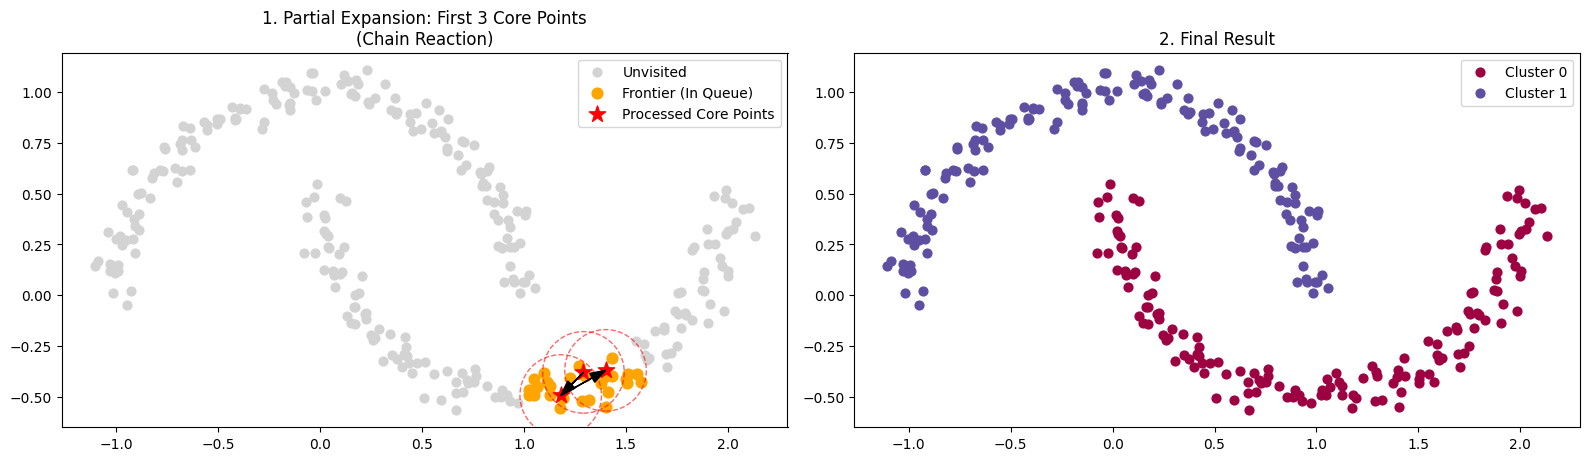

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

# --- 1. Generate Data ---
X, y_true = make_moons(n_samples=300, noise=0.05, random_state=42)

# --- Parameters ---
EPSILON = 0.2
MIN_SAMPLES = 5

# --- 2. Simulation: Run manually for exactly 3 Core Points ---

# State tracking
visited = set()
core_points = []      # The red stars (processed)
frontier = set()      # The orange points (in queue to be processed)

# Pick a starting point (index 10 is deep inside the top moon)
start_idx = 10
queue = [start_idx]
visited.add(start_idx)

# Loop until we have processed 3 Core Points
while len(queue) > 0 and len(core_points) < 3:
    current_idx = queue.pop(0) # Get next point from queue
    
    # Calculate neighbors
    dist = np.linalg.norm(X - X[current_idx], axis=1)
    neighbor_indices = np.where(dist < EPSILON)[0]
    
    # If it's a Core Point (enough neighbors)
    if len(neighbor_indices) >= MIN_SAMPLES:
        core_points.append(current_idx)
        
        # Add neighbors to queue if not visited
        for n_idx in neighbor_indices:
            if n_idx not in visited:
                visited.add(n_idx)
                queue.append(n_idx)
                frontier.add(n_idx)
            
            # If it was in frontier but now processed, remove from frontier set
            if current_idx in frontier:
                frontier.remove(current_idx)

# Convert lists to numpy for easy plotting
core_points_arr = X[core_points]
frontier_arr = X[list(frontier)]

# --- 3. Run Full DBSCAN for Final Result ---
db = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(X)
labels = db.labels_

# --- 4. Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === GRAPH 1: Partial Expansion (3 Hops) ===
# Unvisited Background
axes[0].scatter(X[:, 0], X[:, 1], c='lightgray', s=40, label='Unvisited')

# The Frontier (Neighbors found but not yet processed)
if len(frontier_arr) > 0:
    axes[0].scatter(frontier_arr[:, 0], frontier_arr[:, 1], 
                    c='orange', s=60, label='Frontier (In Queue)')

# The 3 Core Points
axes[0].scatter(core_points_arr[:, 0], core_points_arr[:, 1], 
                c='red', s=150, marker='*', label='Processed Core Points')

# Draw Circles for the 3 Core Points
for point in core_points_arr:
    circle = plt.Circle(point, EPSILON, color='red', fill=False, linestyle='--', alpha=0.6)
    axes[0].add_artist(circle)

# Draw arrows to show the path of expansion
for i in range(len(core_points) - 1):
    p1 = core_points_arr[i]
    p2 = core_points_arr[i+1]
    axes[0].arrow(p1[0], p1[1], p2[0]-p1[0], p2[1]-p1[1], 
                  head_width=0.05, color='black', length_includes_head=True, zorder=10)

axes[0].set_title(f"1. Partial Expansion: First 3 Core Points\n(Chain Reaction)")
axes[0].legend(loc='upper right')
axes[0].set_aspect('equal')


# === GRAPH 2: Final Result ===
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise
        col = [0, 0, 0, 1] 
        label_name = "Noise"
    else:
        label_name = f'Cluster {k}'

    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    axes[1].scatter(xy[:, 0], xy[:, 1], c=[col], s=40, label=label_name)

axes[1].set_title("2. Final Result")
axes[1].legend()
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

#### Conclusion

Data analysis is a very deep and complex field. Most of what quants do is turn data into money. It is very hard to be good at data analysis! And if you are very good at it, you will get paid very well!

I'll leave you with the zen of python [link](https://peps.python.org/pep-0020/).

In [17]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


# Thank you for bearing with me for the last few reviews!